## PREPROCESSING PIPELINE

**PREPROCESSING CONSIDERATIONS (with solutions)**

**I. DOWNSAMPLING**
- Original sampling frequency: 2000 Hz
- Resampling frequency: 500 Hz

**Notes:** 
Aliasing - unwanted freq components due to inappropriate sampling.

*EEGLab recommendations*
You may downsample the data to around 250Hz if the original sampling frequency is higher than that. Usually low-pass filter is necessary before downsampling for anti-aliasing, but EEGLAB function applies the anti-aliasing filter automatically. It is also recommended by Zapline aothors (see below) to ensure optimal perfomance o fthe Zapline filter. Downsampling is useful to compress the data size. It also help ICA to produce better decomposition by cutting off unnecessary high-frequency information, though we have not tested it quantitatively.


*MNE recommendations*
To avoid the reduction in temporal precision of events that comes with resampling a Raw object, and also avoid the edge artifacts that come with filtering an Epochs or Evoked object, the best practice is to:

1. low-pass filter the Raw data at or below 1/3 of the desired sample rate, then
2. decimate the data after epoching, by either passing the decim parameter to the Epochs constructor, or using the decimate() method after the Epochs have been created.

If for some reason you cannot follow the above-recommended best practices, you should at the very least either:
1. resample the data after epoching, and make your epochs long enough that edge effects from the filtering do not affect the temporal span of the epoch that you hope to analyze / interpret; or
2. **perform resampling on the Raw object and its corresponding Events array simultaneously so that they stay more or less in synch. This can be done by passing the Events array as the events parameter to raw.resample().**

**SOLUTION:** Downsample raw data (before applying Zapline) in EEGlab (using *LoadCNT_Katya.m*). Anti-aliasing filter is applied automatically (no low-pass needed).

**II. POWERLINE NOISE:** I compared PSD plots for notch_filter, prectrum_fit (multitaper) and zapline (EEGLAB) -> notch - dips at 50Hz and 100Hz; multitaper - better, but has a small bump at 50Hz, also not well described in the documentation; zapline - nice output. Raw.plots() looked comparable for all three options. Zapline is validated by the literature. **SOLUTION:** zapline.
References for this solution: 
    1.Original method: Cheveigné, A. de. ZapLine: A simple and effective method to remove power line artifacts. NeuroImage 207, 116356 (2020).
    2.Adaptation for EEGLAB: Klug, M. & Kloosterman, N. A. Zapline‐plus: A Zapline extension for automatic and adaptive removal of frequency‐specific noise artifacts in M/EEG. Hum. Brain Mapp. 43, 2743–2758 (2022).

**III. Conversion to .SET format compatible with MNE Python**

Options:
1. ANT eego format (.cnt) -> issues with reading the file.
2. Brainvision format (.eeg + .vhdr + .vmrk) -> all good, but there were concerns about loosing some events (impedance checks and amp reload triggers) + we wanted to use *zapline* for powerline (50 Hz + harmonics) filtering which gives a MemoryError when implemented in Python (*dss.dss_line()* from meegkit). Downsampling to 500Hz and transposing the data did not solve the issue. I tried to discuss it on the MNE forum, but did not come up with the solution in the end.
3. Used EEGLAB (Matlab) to apply zapline to the EEG data (.cnt), converted it to .set + .fdt first. Then imported the powerline filtered data to MNE using *mne.io.read_raw_eeglab()* function. -> **optimal solution**

**IV. Drop mastoids and set PROTODIODE to be a MISC channel**

Mastoids: TP9-10, we do not use them -> drop

Photodiode: BIP3 -> misc



**V. Apply 10-20 montage**

**VI. Marking BAD channels and BAD segments**

*PYPREP*

Reserences:

Example: https://pyprep.readthedocs.io/en/stable/auto_examples/run_ransac.html#sphx-glr-auto-examples-run-ransac-py
NoiseChannels class and it's functions: https://pyprep.readthedocs.io/en/stable/generated/pyprep.NoisyChannels.html#pyprep.NoisyChannels

Applied:
**find_all_bads(ransac=True, channel_wise=False, max_chunk_size=None)**

Call all the functions to detect bad channels.

This function calls all the bad-channel detecting functions.

Parameters:
ransacbool, optional
Whether RANSAC should be used for bad channel detection, in addition to the other methods. RANSAC can detect bad channels that other methods are unable to catch, but also slows down noisy channel detection considerably. Defaults to True.

channel_wisebool, optional
Whether RANSAC should predict signals for chunks of channels over the entire signal length (“channel-wise RANSAC”, see max_chunk_size parameter). If False, RANSAC will instead predict signals for all channels at once but over a number of smaller time windows instead of over the entire signal length (“window-wise RANSAC”). Channel-wise RANSAC generally has higher RAM demands than window-wise RANSAC (especially if max_chunk_size is None), but can be faster on systems with lots of RAM to spare. Has no effect if not using RANSAC. Defaults to False.

max_chunk_size{int, None}, optional
The maximum number of channels to predict at once during channel-wise RANSAC. If None, RANSAC will use the largest chunk size that will fit into the available RAM, which may slow down other programs on the host system. If using window-wise RANSAC (the default) or not using RANSAC at all, this parameter has no effect. Defaults to None.

**VII. Re-reference channels**

*from MNE website:*

If using an average reference, it is possible to create the reference as a projector rather than subtracting the reference from the data immediately by specifying projection=True.

Creating the average reference as a projector has a few advantages:

* It is possible to turn projectors on or off when plotting, so it is easy to visualize the effect that the average reference has on the data.

* If additional channels are marked as “bad” or if a subset of channels are later selected, the projector will be re-computed to take these changes into account (thus guaranteeing that the signal is zero-mean).

* If there are other unapplied projectors affecting the EEG channels (such as SSP projectors for removing heartbeat or blink artifacts), EEG re-referencing cannot be performed until those projectors are either applied or removed; adding the EEG reference as a projector is not subject to that constraint.

* If you plan to perform source modeling (either with EEG or combined EEG/MEG data), it is strongly recommended to use the average-reference-as-projection approach. It is important to use an average reference because using a specific reference sensor (or even an average of a few sensors) spreads the forward model error from the reference sensor(s) into all sensors, effectively amplifying the importance of the reference sensor(s) when computing source estimates. In contrast, using the average of all EEG channels as reference spreads the forward modeling error evenly across channels, so no one channel is weighted more strongly during source estimation. See also this FieldTrip FAQ on average referencing for more information.

The main reason for specifying the average reference as a projector was mentioned in the previous section: an average reference projector adapts if channels are dropped, ensuring that the signal will always be zero-mean when the source modeling is performed. In contrast, applying an average reference by the traditional subtraction method offers no such guarantee.

**Average reference as the projector notes:**

*It is best to compute projectors only on channels that will be used (e.g., excluding bad channels). This ensures that projection vectors will remain ortho-normalized and that they properly capture the activity of interest.*

Best practices:
* In general, it is recommended to apply projectors when creating Epochs from Raw data. There are two reasons for this recommendation:
* It is computationally cheaper to apply projectors to data after the data have been reducted to just the segments of interest (the epochs)
* If you are applying amplitude-based rejection criteria to epochs, it is preferable to reject based on the signal after projectors have been applied, because the projectors may reduce noise in some epochs to tolerable levels (thereby increasing the number of acceptable epochs and consequenty increasing statistical power in any later analyses).

**VIII. Band-pass filtering**

0.5-80Hz

**IX. Bad segments**

Manual annotation using *raw.plot()*

**X. Independent component analysis (ICA)**

______________________________________________

**CONCLUSION:**
**How to deal with the raw data?**

**STEP 0**
- Export data from eego in .cnt format (*untick* Apply Montage) option

**STEP 1**
- Import .cnt data into EEGLAB (Matlab) using *LoadCNT_Katya.m* script to downsample, apply zapline and convert it to .set + .fdt format
- Import the powerline filtered data into MNE using *mne.io.read_raw_eeglab()*
- Check the data for powerline noise and events

**STEP 3**
- Proceed with the preprocessing. *To be continued...*

In [2]:
import numpy as np
import mne

In [5]:
current_sfreq = 2000 # raw.info["sfreq"]
desired_sfreq = 500  # Hz
decim = np.round(current_sfreq / desired_sfreq).astype(int)
obtained_sfreq = current_sfreq / decim
lowpass_freq = obtained_sfreq / 3.0

print('Current freq:', current_sfreq, '\n'
      'Decimation:', decim, '\n'
      'Desired freq:', obtained_sfreq, '\n'
      'Low-pass freq:', lowpass_freq.astype(int))


Current freq: 2000 
Decimation: 4 
Desired freq: 500.0 
Low-pass freq: 166


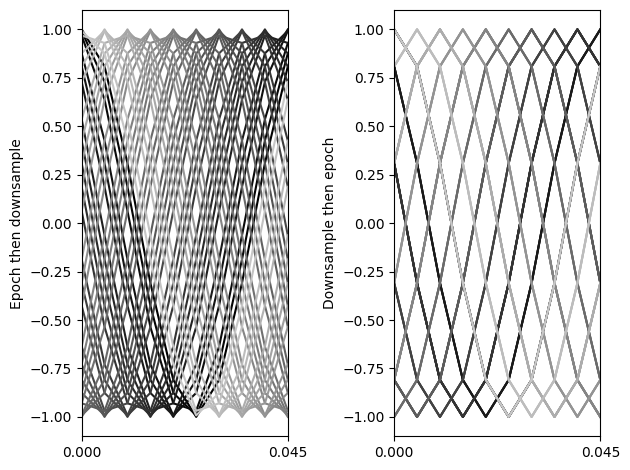

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 1 sec of data @ 1000 Hz
fs = 1000.  # Hz
decim = 5
n_samples = 1000
freq = 20.  # Hz
t = np.arange(n_samples) / fs
epoch_dur = 1. / freq  # 2 cycles of our sinusoid

# we have a 10 Hz sinusoid signal
raw_data = np.cos(2 * np.pi * freq * t)

# let's make events that should show the sinusoid moving out of phase
# continuously
n_events = 40
event_times = np.linspace(0, 1. / freq, n_events, endpoint=False)
event_samples = np.round(event_times * fs).astype(int)
data_epoch = list()
epoch_len = int(round(epoch_dur * fs))
for event_time in event_times:
    start_idx = int(np.round(event_time * fs))
    data_epoch.append(raw_data[start_idx:start_idx + epoch_len])
data_epoch = np.array(data_epoch)
data_epoch_ds = data_epoch[:, ::decim]

# now let's try downsampling the raw data instead
raw_data_ds = raw_data[::decim]
fs_new = fs / decim
data_ds_epoch = list()
epoch_ds_len = int(round(epoch_dur * fs_new))
for event_time in event_times:
    start_idx = int(np.round(event_time * fs_new))
    data_ds_epoch.append(raw_data_ds[start_idx:start_idx + epoch_ds_len])
data_ds_epoch = np.array(data_ds_epoch)

# Look at the results
assert data_ds_epoch.shape == data_epoch_ds.shape
fig, axs = plt.subplots(1, 2)
t_ds = np.arange(epoch_ds_len) / fs_new
for di, (data_e_d, data_d_e) in enumerate(zip(data_epoch_ds, data_ds_epoch)):
    color = [di / float(n_events + 10)] * 3
    axs[0].plot(t_ds, data_e_d, color=color)
    axs[1].plot(t_ds, data_d_e, color=color)
axs[0].set_ylabel('Epoch then downsample')
axs[1].set_ylabel('Downsample then epoch')
for ax in axs:
    ax.set_xlim(t_ds[[0, -1]])
    ax.set_xticks(t_ds[[0, -1]])
fig.set_tight_layout(True)